# Custom version of Stable Diffusion

In [13]:
!pip install transformers diffusers ftfy

  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [6]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [57]:
import torch
from matplotlib import pyplot as plt

In [7]:
from transformers import CLIPTextModel, CLIPTokenizer

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [22]:
from diffusers import AutoencoderKL, UNet2DConditionModel

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [19]:
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

## Making Text Embeddings for the Unet

In [164]:
prompt = ["a photograph of an astronaut riding a horse"]

In [165]:
token_info = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")

token_embs = text_encoder(token_info.input_ids.to("cuda"))[0];
token_embs.shape

torch.Size([1, 77, 768])

In [166]:
uncond_info = tokenizer([""] * len(prompt), padding="max_length", truncation=True, return_tensors="pt")

uncond_embs = text_encoder(uncond_info.input_ids.to("cuda"))[0]
uncond_embs.shape

torch.Size([1, 77, 768])

In [167]:
text_embs = torch.cat([uncond_embs, token_embs])
text_embs.shape

torch.Size([2, 77, 768])

## Initialize Latents & Schedular

In [168]:
height = 512
width = 512
steps = 50

In [169]:
torch.manual_seed(100)
latents = torch.randn(len(prompt), unet.in_channels, height // 8, width // 8).to("cuda").half()
latents.shape

torch.Size([1, 4, 64, 64])

In [170]:
scheduler.set_timesteps(50)

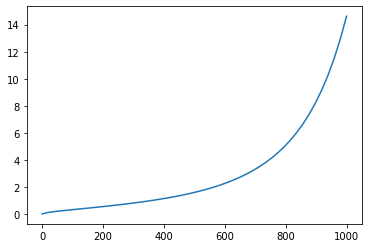

In [171]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])

In [172]:
latents = latents * scheduler.init_noise_sigma

## The Loop

In [173]:
from tqdm.auto import tqdm

In [174]:
guidance_scale = 7.5

In [175]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embs).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    updated_info = scheduler.step(pred, t, latents)
    latents = updated_info.prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

## Latent to the Image

In [176]:
with torch.no_grad():
    im_data = vae.decode(latents * 1 / 0.18215).sample[0]

In [177]:
norm_im_data = (im_data * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
norm_im_data.shape

(512, 512, 3)

In [178]:
rgb_im_data = (norm_im_data * 255).round().astype("uint8")

In [179]:
from PIL import Image

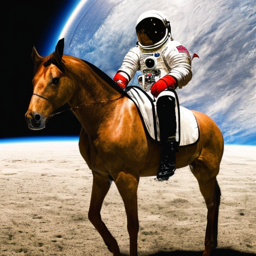

In [183]:
Image.fromarray(rgb_im_data).resize((256, 256))